# N-Body Simulation

We can make simulations approximating the universe's behaviour using N-body simulations.  In these simulations we use a large number of point masses (approximating galaxies) that interact gravitationally.  The following notebook will walk you through the code necessary to produce a simulation as well as the physical conclusions that we can make with our output.

So grab yourself a snack and a glass of orange juice and try not to reach through the screen because HERE WE GOOO!

## Defining Parameters

In this section we will define the parameters that will dictate the evolution of our particles.  All of these parameters are in natural units.  In other words, we do not have physical constants to scale the units of our simulation.  Given the simplicity of this simulation, it is easiest to understand with these units.

First we need to import our packages:

In [1]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Our initial conditions for the positions and velocities are going to be randomised so we need to supply a seed:

In [2]:
np.random.seed(4080)

Choose whether you want a 2-D projection (recommended) or a 3-D projection:

In [3]:
project_3d = False

In [4]:
print(project_3d)

False


Set the number of spatial dimensions (2 or 3):

In [7]:
output_slider_variable = widgets.Text()
def f(Nd):
    output_slider_variable.value = str(Nd)
interact(f,Nd=(2,3));

interactive(children=(IntSlider(value=2, description='Nd', max=3, min=2), Output()), _dom_classes=('widget-int…

In [ ]:
Nd = int(output_slider_variable.value)
print(Nd)

Set the number of particles (or galaxies) to simulate:

In [9]:
def f(Np):
    output_slider_variable.value = str(Np)
interact(f,Np=(10,1000));

interactive(children=(IntSlider(value=505, description='Np', max=1000, min=10), Output()), _dom_classes=('widg…

In [10]:
Np = int(output_slider_variable.value)

Set the total number of timesteps (i.e. how long you want the simulation to run for):

In [11]:
def f(Nt):
    output_slider_variable.value = str(Nt)
Nt = interact(f,Nt=(10,1000));

interactive(children=(IntSlider(value=505, description='Nt', max=1000, min=10), Output()), _dom_classes=('widg…

In [13]:
Nt = int(output_slider_variable.value)

Set how long the animation should dispay each timestep (in milliseconds):

In [14]:
def f(frame_duration):
    output_slider_variable.value = str(frame_duration)
frame_duration = interact(f,frame_duration=(10,1000));

interactive(children=(IntSlider(value=505, description='frame_duration', max=1000, min=10), Output()), _dom_cl…

In [15]:
frame_duration = int(output_slider_variable.value)

We will randomly generate velocities for each galaxy.  v_max gives the maximum possible velocity we can generate for a given direction:

In [16]:
def f(v_max):
    output_slider_variable.value = str(v_max)
interact(f,v_max=(0.0,0.1,0.01));

interactive(children=(FloatSlider(value=0.05, description='v_max', max=0.1, step=0.01), Output()), _dom_classe…

In [17]:
v_max = double(output_slider_variable.value)

Set the mass of all of the galaxies (recommended mass is 0.00001):

In [18]:
def f(mass):
    output_slider_variable.value = str(mass)
    return mass
interact(f,mass=(0.0,1e-04,1e-05));

interactive(children=(FloatSlider(value=5e-05, description='mass', max=0.0001, step=1e-05), Output()), _dom_cl…

In [19]:
mass = double(output_slider_variable.value)

In the real universe, when objects get close to each other, they collide.  To reproduce this effect approximately, we will modify our gravitational equation to simulate collisions.  This is called softening and s_len gives the length at which this interaction becomes important.  Our simulation is a cube/square with a side length of 2.  Thus, our softening length should be small compared to the size of the cube:

In [21]:
def f(s_len):
    output_slider_variable.value = str(s_len)
    return s_len
interact(f,s_len=(0.0,1.0,0.001));

interactive(children=(FloatSlider(value=0.5, description='s_len', max=1.0, step=0.001), Output()), _dom_classe…

In [22]:
s_len = double(output_slider_variable.value)

Correlation functions track the preference for galaxies to have a specific separation.  We will elaborate on this later in this notebook, but here we set the correlation function bins.  In other words we are setting the resolution of our correlation function.  It has to be small enough so that a non-negligible number of galaxies fall in each bin but large enough to give a resolution that we can make conclusions from:

In [23]:
def f(ncorrbins):
    output_slider_variable.value = str(ncorrbins)
    return ncorrbins
interact(f,ncorrbins=(10,100));

interactive(children=(IntSlider(value=55, description='ncorrbins', min=10), Output()), _dom_classes=('widget-i…

In [24]:
ncorrbins = int(output_slider_variable.value)

Here we generate a set of initial positions and velocities.  We initialise a separate set of positions for use with our correlation function (we will elaborate on this later):

In [25]:
#Set initial positions at random within box:
position = 1-2*np.random.random((Nd,Np))

#Set random positions for correlation function:
rand_position = 1-2*np.random.random((Nd,Np))

# Set initial velocities to be random fractions of the maximum
velocity = v_max*(1-2*np.random.random((Nd,Np)))

## Defining our Functions

Here we define our acceleration.  We simply use the following relation for gravitation:
\begin{eqnarray}
\vec{F_i} = \Sigma_{i \neq j}\frac{\vec{r_i} - \vec{r_j}}{|\vec{r_i}-\vec{r_j}|^3} \\
\end{eqnarray}
As we stated earlier, we need to apply softening to this equation.  We chose to make it $\frac{L_s}{r^3} - 1$ so that it only becomes important when $r$ is significant compared to $L_s$.  Scaling with our softening length $L_s$.  Thus, we have used the following relation:
\begin{eqnarray}
\vec{F_i} = \Sigma_{i \neq j}\left(1 - \frac{L_s}{|\vec{r_i}-\vec{r_j}|^3}\right) \frac{\vec{r_i} - \vec{r_j}}{|\vec{r_i}-\vec{r_j}|^3} \\
\end{eqnarray}

In [26]:
def acceleration(mass,slen,p):
    a = np.random.random((Nd,Np))
    for i in range(len(p[0])):
        for k in range(len(a)):
            a[k][i] = 0.0
        for j in range(len(p[0])):
            r = 0
            if i != j:
                for k in range(len(a)):
                    r += (p[k][i] - p[k][j])**2
                for k in range(len(a)):
                    a[k][i] += -(1 - (slen/np.sqrt(r))**3)*mass*(p[k][i] - p[k][j])/(np.sqrt(r)**3)
    return a

In this simulation, we are using periodic boundary conditions.  This means that our simulation area operates like Pacman, if a particle moves out of the left side of the area it will enter throught the right:

In [27]:
# Create a function to apply boundary conditions
def apply_boundary(p):
    for i in range(len(p)):
        for j in range(len(p[0])):
            if abs(p[i][j]) > 1:
                p[i][j] = -p[i][j]
    return p

Here we define a function that gives the separation between 2 masses, used in calculating the correlation function.

In [28]:
#Finds the separation between 2 masses.
def separation(p1,p2):
    sep = []
    for i in range(len(p1[0])):
        for j in range(len(p2[0])):
            r = 0
            if i != j:
                for k in range(len(p1)):
                    r += (p1[k][i] - p2[k][j])**2
                sep.append(np.sqrt(r))
    return sep

Here, we define our correlation function.  Correlation functions define the departure from a random distribution across a range of length scales.  In other words, how much is 'clumpiness' is there, compared to a random distribution, at a given length scale, $r$.  We use the Landy-Szalay relation for the correlation function:

\begin{eqnarray}
    \zeta_{LS} = \frac{DD(r) - 2DR(r) + RR(r)}{RR(r)}
\end{eqnarray}

Where, at a given separation, $r$, $DD(r)$ is the density of galaxies in our simulation data, $DR(r)$ is the separation between galaxies in our data and the random distribution and $RR(r)$ is the density of galaxies in a random distribution.

In [29]:
#Correlation Function
def correlation_func(d,r,x,dx):
    #These vectors store the separations between data, random points and data
    #and random points.
    DDsep = separation(d,d)
    DRsep = separation(d,r)
    RRsep = separation(r,r)

    #These vectors have the number of masses binned at a given separations.
    DD = np.zeros(len(x))
    DR = np.zeros(len(x))
    RR = np.zeros(len(x))

    for i in range(len(DDsep)):
        for j in range(len(x)-1):
            #If there is a separation within a given bin, add 1 to the count.
            if DDsep[i] > xb[j] and DDsep[i] < xb[j+1]:
                DD[j] += 1
            if DRsep[i] > xb[j] and DRsep[i] < xb[j+1]:
                DR[j] += 1
            if RRsep[i] > xb[j] and RRsep[i] < xb[j+1]:
                RR[j] += 1

    corr = np.divide(np.add(DD,np.add(-2*DR,RR)),RR)
    for i in range(len(corr)):
        #Setting any nans or infs to 0 (for future calculations).
        if np.isnan(corr[i]) or np.isinf(corr[i]):
            corr[i] = 0
    return corr

Now we define the power spectrum, $P(k)$, which is the Fourier Transform of the correlation function:
    
\begin{eqnarray}
    P(k) = 2\pi\int^{\infty}_{0}dr r^2 \frac{sin(kr)}{kr} \zeta(r)
\end{eqnarray}

Where k is the wavenumber.

In [30]:
def power_spec(xb,kb,cor):
    pk = []
    #Integrating for a range of k-values (given by kb):
    pk.append([np.trapz(2.0*np.pi*np.multiply(np.multiply(xb,np.sin(i*xb)),cor)*(1.0/i),xb) for i in kb])
    return pk

The following code generates and plots the simulation.  We will be able to see how the correlation function and power spectrum evolves with time, as the galaxies gravitationally interact.

<ipython-input-29-21c86281504d>:24: RuntimeWarning: invalid value encountered in true_divide
  corr = np.divide(np.add(DD,np.add(-2*DR,RR)),RR)


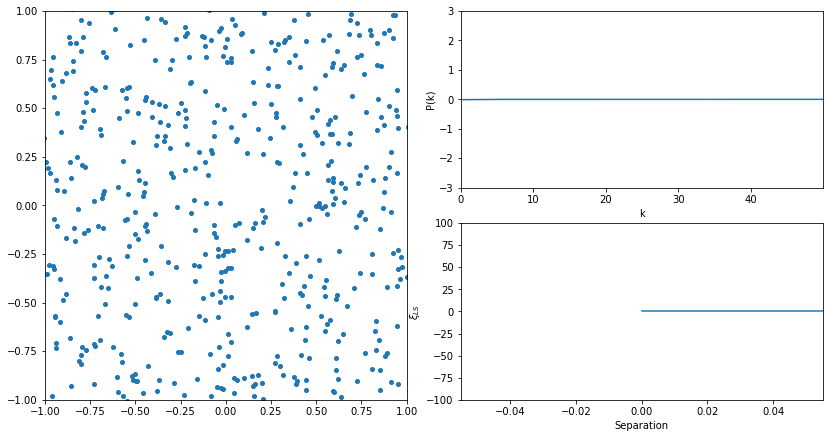

<ipython-input-29-21c86281504d>:24: RuntimeWarning: invalid value encountered in true_divide
  corr = np.divide(np.add(DD,np.add(-2*DR,RR)),RR)


In [ ]:
plt.ion() # Set interactive mode on
fig = figure(figsize=(12,6)) # Create frame and set size
subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,wspace=0.15,hspace=0.2)
# Create one set of axes as the left hand panel in a 1x2 grid
if project_3d:
    ax1 = subplot(121,projection='3d') # For very basic 3D projection
else:
    ax1 = subplot(121) # For normal 2D projection
xlim(-1,1)  # Set x-axis limits
ylim(-1,1)  # Set y-axis limits

if project_3d:
    points, = ax1.plot([],[],[],'o',markersize=4)  ## For 3D projection
else:
    points, = ax1.plot([],[],'o',markersize=4) ## For 2D projection

ax2 = subplot(222) # Create second set of axes as the top right panel in a 2x2 grid
xmax = 6 # Set xaxis limit
xlabel('k')
ylabel('P(k)')
dk=0.1 # Set width of x-axis bins
kb = np.arange(0,50.0,dk)  # Set x-axis bin edges
kb[0] = 1e-6 # Shift first bin edge by a fraction to avoid showing all the zeros (a cheat, but saves so much time!)
xlim(0,kb[-1])
ylim(-3.0,3.0) # Reasonable guess for suitable yaxis scale
line1, = ax2.plot([],[]) # Define a command that plots a line in this panel

ax4 = plt.subplot(224) # Create last set of axes as the bottom right panel in a 2x2 grid
xlabel('Separation')
ylabel(r'$\xi_{LS}$')
dx=0.05 # Set width of x-axis bins
xb = np.arange(0,1.0+dx,dx)  # Set x-axis bin edges
xb[0] = 1e-6 # Shift first bin edge by a fraction to avoid showing all the zeros (a cheat, but saves so much time!)
ylim(-100,100) # Reasonable guess for suitable yaxis scale
line2, = ax4.plot([],[],drawstyle='steps-post')

# Define procedure to update positions at each timestep
def update(i):
    global position,velocity # Get positions and velocities
    velocity += acceleration(mass,s_len,position)
    position += velocity # Increment positions according to their velocites
    position = apply_boundary(position) # Apply boundary conditions
    points.set_data(position[0,:], position[1,:]) # Show 2D projection of first 2 position coordinates
    correlation = correlation_func(position,rand_position,xb,dx)
    power = power_spec(xb,kb,correlation)
    if project_3d:
        points.set_3d_properties(position[2,:])  ## For 3D projection
    line1.set_data(kb,power) # Set the new data for the line in the 2nd panel
    line2.set_data(xb,correlation) # Set the new data for the line in the 2nd panel
    return points,line1,line2 # Plot the points and the line

# Create animation
# https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html
ani = animation.FuncAnimation(fig, update, frames=Nt,interval = frame_duration)

plt.show()
# To save as an mpeg file try:
ani.save("drifters.mp4")